In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.io
import src.utils

%matplotlib inline

In [2]:
def generate_blocks_with_offset(Nblocks, blocklen, offset):
    '''
    Generate a session with Nblocks blocks, each block of length
    blocklen trials, and all of them has an offset given by offset
    '''
    blocks = np.zeros((Nblocks, blocklen))
    blocks[:,:offset] = 1
    return blocks


def generate_blocks_with_sigmoid(Nblocks, blocklen, offset, slope, lapse):
    '''
    Generate a session with Nblocks blocks, each block of length
    blocklen trials, governed by transition function with parameters
    (offset, slope, lapse)
    '''
    x = np.arange(blocklen)
    transfunc = sigmoid(x, offset, slope, lapse)
    blocks = np.random.rand(Nblocks, blocklen) > transfunc
    return blocks, transfunc



def sigmoid(x, offset, slope, lapse):
    return (1 - 2*lapse) / (1 + np.exp(-(x - offset) * slope)) + lapse


In [3]:
def resample_block(block, Ntrials):
    '''
    Resample Ntrials times while maintaining the bigram statistics
    '''
    choicelst = [resample_helper(block) for i in range(Ntrials)]
    return np.array(choicelst)


def resample_helper(block):
    '''
    Resample block a single time maintaining the bigram statistics
    '''
    N, T = block.shape
    choices = []
    for i in range(T):
        if i == 0:
            trials = block[:,i]
            
            
        else:
            prevtrials = block[:,i-1]
            trials = block[prevtrials == sample,i]
    
    
        sample = np.random.choice(trials)
        choices.append(sample)
        
    return choices

    
    
    
    
    

In [4]:
def unfold_block(block):
    '''
    Given a block, unfold into three flattened arrays:
    choices, outcomes, choices x outcomes
    
    '''
    outcomes = (1 - np.reshape(block, (-1, 1))) * 2 - 1
    block = block * 2 - 1
    block[::2,:] = block[::2,:] * -1
    choices = np.reshape(block, (-1, 1))
    
    return outcomes, choices
    
    
def make_Xy(block, N=1):
    '''
    block: raw data block, of shape Nblocks x trials
    N: number of trials back in the past to extract for the regression
    Returns:
    Xmat: Xmatrix of shape (Nblocks x trials - 3N) x (3N),
    arranged as blocks of [choice history; outcome history; choice x outcome history]
    in each block there are N columns, corresponding to (t-N, ..., t-2, t-1)
    y: y vector, the choice
    
    '''
    outcomes, choices = unfold_block(block)
    outcomesXchoices = outcomes * choices
    
    y = choices[N:].ravel()
    
    choicehistory = []
    outcomehistory = []
    choiceoutcomehistory = []
    
    for i in range(N):  
        X1 = choices[i:-N+i]
        X2 = outcomes[i:-N+i]
        X3 = outcomesXchoices[i:-N+i]
        choicehistory.append(X1)
        outcomehistory.append(X2)
        choiceoutcomehistory.append(X3)
    
#     print(choicehistory[0].shape, outcomehistory[0].shape, choiceoutcomehistory[0].shape)
#     print(len(choicehistory), len(outcomehistory), len(choiceoutcomehistory))
#     print(len(choicehistory + outcomehistory + choiceoutcomehistory))
    Xmat = np.hstack(choicehistory + outcomehistory + choiceoutcomehistory)
    
    return choicehistory, outcomehistory, choiceoutcomehistory, Xmat, y
    
    

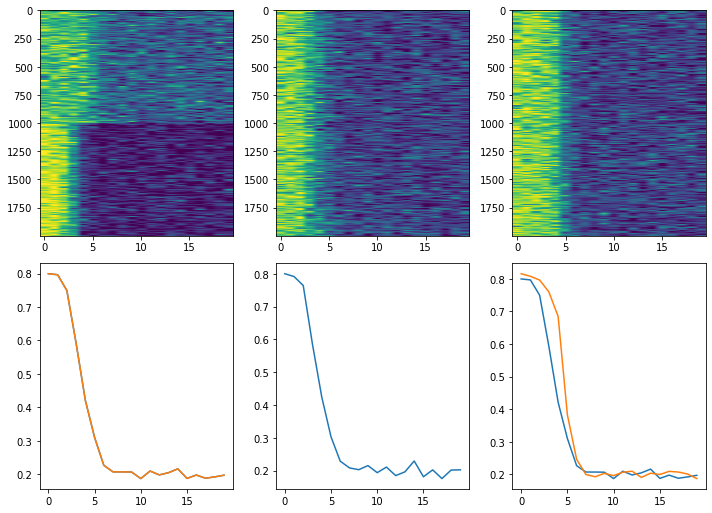

In [136]:
# np.random.seed('shuffle')
seed = 123
np.random.seed(seed)
Nblocks = 1000
blocklen = 20
# ok parameters for simple simulations
# offset1 = 5
# offset2 = 1
# slope1 = 0.6
# slope2 = 0.6
# lapse1 = 0
# lapse2 = 0

offset1 = 5
offset2 = 3
slope1 = 2
slope2 = 2
lapse1 = 0.3
lapse2 = 0.1

offset3 = 4.6
slope3 = 2
lapse3 = 0.2

block1, t1 = generate_blocks_with_sigmoid(Nblocks, blocklen, offset1, slope1, lapse1)
block2, t2 = generate_blocks_with_sigmoid(Nblocks, blocklen, offset2, slope2, lapse2)
block = np.vstack([block1, block2])
newblock = resample_block(block, block.shape[0])
order = np.random.permutation(block.shape[0])
shuffleblock2 = block[order,:]
shuffleblock, t3 = generate_blocks_with_sigmoid(2 * Nblocks, blocklen, offset3, slope3, lapse3)

plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(block, aspect='auto')

plt.subplot(232)
plt.imshow(newblock, aspect='auto')

plt.subplot(233)
plt.imshow(shuffleblock, aspect='auto')
plt.tight_layout()

plt.subplot(234)
plt.plot(np.mean(block, axis=0))
plt.plot(np.mean(shuffleblock2, axis=0))


plt.subplot(235)
plt.plot(np.mean(newblock, axis=0))

plt.subplot(236)
plt.plot(np.mean(block, axis=0))
plt.plot(np.mean(shuffleblock, axis=0))



In [137]:
Nmax = 16
a,b,c,Xmat, y = make_Xy(block, Nmax)
mdl = sklearn.linear_model.LogisticRegression()
mdl.fit(Xmat, y)


_,_,_,Xmat2, y2 = make_Xy(shuffleblock2, Nmax)
mdl2 = sklearn.linear_model.LogisticRegression()
mdl2.fit(Xmat2, y2)


_,_,_,Xmat3, y3 = make_Xy(shuffleblock, Nmax)
mdl3 = sklearn.linear_model.LogisticRegression()
mdl3.fit(Xmat3, y3)





LogisticRegression()

(-2.0, 1.0)

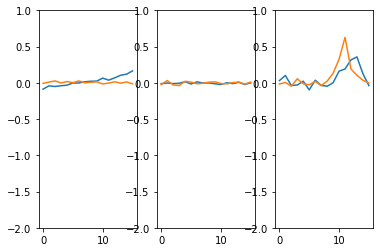

In [138]:
plt.subplot(131)
plt.plot(mdl.coef_[0][:Nmax]);
plt.plot(mdl3.coef_[0][:Nmax]);
# plt.plot(mdl3.coef_[0][:Nmax]);
plt.ylim([-2, 1])

plt.subplot(132)
plt.plot(mdl.coef_[0][Nmax:2*Nmax]);
plt.plot(mdl3.coef_[0][Nmax:2*Nmax]);
# plt.plot(mdl3.coef_[0][Nmax:2*Nmax]);
plt.ylim([-2, 1])


plt.subplot(133)
plt.plot(mdl.coef_[0][2*Nmax:3*Nmax]);
plt.plot(mdl3.coef_[0][2*Nmax:3*Nmax]);
# plt.plot(mdl3.coef_[0][2*Nmax:3*Nmax]);
plt.ylim([-2, 1])


In [134]:
# Save data
paths = src.utils.pathsetup('matchingsim')
scipy.io.savemat(f"{paths['codepath']}/history/shuffle_simulation_results_lapse0.1_013022_v7.mat", dict(block=block, 
                    newblock=newblock, shuffleblock=shuffleblock, Xmat=Xmat, y=y,
                    Xmat2=Xmat2, y2=y2, Xmat3=Xmat3, y3=y3, offset1=offset1, offset2=offset2,
                    offset3=offset3, slope1=slope1, slope2=slope2, slope3=slope3,
                    lapse1=lapse1, lapse2=lapse2, lapse3=lapse3, coef1=mdl.coef_, coef3=mdl3.coef_, seed=seed))

In [42]:
dict(block=block, 
                    newblock=newblock, shuffleblock=shuffleblock, Xmat=Xmat, y=y,
                    Xmat2=Xmat2, y2=y2, Xmat3=Xmat3, y3=y3, offset1=offset1, offset2=offset2,
                    offset3=offset3, slope1=slope1, slope2=slope2, slope3=slope3,
                    lapse1=lapse1, lapse2=lapse2, lapse3=lapse3, coef1=mdl.coef_, coef3=mdl3.coef_)

{'block': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False,  True, False],
        [ True, False,  True, ..., False, False, False],
        ...,
        [ True, False,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]),
 'newblock': array([[ True,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False,  True]]),
 'shuffleblock': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        

In [111]:
def generate_and_fit_history_regression():
    Nblocks = 1000
    blocklen = 15

    offset1 = 5
    offset2 = 3
    slope1 = 0.6
    slope2 = 2
    lapse1 = 0.1
    lapse2 = 0.1

    offset3 = 3.5
    slope3 = 0.85
    lapse3 = 0.1

    coefs_all1 = []
    coefs_all3 = []
    
    block1, t1 = generate_blocks_with_sigmoid(Nblocks, blocklen, offset1, slope1, lapse1)
    block2, t2 = generate_blocks_with_sigmoid(Nblocks, blocklen, offset2, slope2, lapse2)
    block = np.vstack([block1, block2])
    shuffleblock, t3 = generate_blocks_with_sigmoid(2 * Nblocks, blocklen, offset3, slope3, lapse3)
    
    Nmax = 16
    a,b,c,Xmat, y = make_Xy(block, Nmax)
    mdl = sklearn.linear_model.LogisticRegression()
    mdl.fit(Xmat, y)

    _,_,_,Xmat3, y3 = make_Xy(shuffleblock, Nmax)
    mdl3 = sklearn.linear_model.LogisticRegression()
    mdl3.fit(Xmat3, y3)
    
    return mdl, mdl3

In [112]:
coefs_all1 = []
coefs_all3 = []
for i in range(10):
    mdl, mdl3 = generate_and_fit_history_regression()
    coefs_all1.append(mdl.coef_[0])
    coefs_all3.append(mdl3.coef_[0])

coefsarr1 = np.array(coefs_all1)
coefsarr3 = np.array(coefs_all3)

<ErrorbarContainer object of 3 artists>

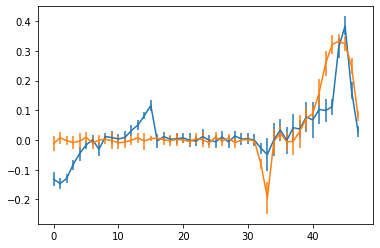

In [113]:
plt.errorbar(np.arange(len(coefsarr1[0])), np.mean(coefsarr1, axis=0), np.std(coefsarr1, axis=0))
plt.errorbar(np.arange(len(coefsarr1[0])), np.mean(coefsarr3, axis=0), np.std(coefsarr3, axis=0))

In [91]:
np.std(coefsarr1, axis=0)

array([1.38777878e-17, 0.00000000e+00, 1.38777878e-17, 6.93889390e-18,
       0.00000000e+00, 6.93889390e-18, 3.46944695e-18, 0.00000000e+00,
       0.00000000e+00, 3.46944695e-18, 1.73472348e-18, 2.16840434e-19,
       8.67361738e-19, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.46944695e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.46944695e-18, 0.00000000e+00, 6.93889390e-18, 0.00000000e+00,
       6.93889390e-18, 6.93889390e-18, 0.00000000e+00, 0.00000000e+00,
       3.46944695e-18, 3.46944695e-18, 1.73472348e-18, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.46944695e-18, 0.00000000e+00,
       6.93889390e-18, 3.46944695e-18, 1.38777878e-17, 6.93889390e-18,
       2.77555756e-17, 1.38777878e-17, 0.00000000e+00, 5.55111512e-17,
       5.55111512e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])